# **PROJECT BY: SYEDA UMAIMA TAMKEEN**  

# **Project Title:** Karachi Livability Index Analysis and Visualization  

# **Summary:**  
In this project, I developed a composite **Livability Index** for Karachi using environmental and weather-related features to evaluate daily living conditions. The objective was to combine air quality, temperature comfort, and humidity comfort into a single index ranging from 0 to 100, where 100 represents the most livable conditions. The analysis also involved data visualization to track livability trends over time and identify periods of low environmental comfort.  

# **Key Steps:**  

**1. Data Loading and Preparation:**  
- Imported the processed dataset (`karachi_daily_features.csv`) containing daily environmental and weather data.  
- Parsed the `date` column as a datetime object for time-series analysis.  

**2. Feature Engineering – Score Calculation:**  
- **Air Quality Score:** Calculated as `100 - PM2.5 Index (0-100)` to give higher scores for cleaner air.  
- **Temperature Comfort Score:** Penalized deviations from the ideal 25°C by subtracting `3 × deviation` from 100.  
- **Humidity Comfort Score:** Penalized deviations from the ideal 50% humidity by subtracting `2 × deviation` from 100.  

**3. Livability Index Computation:**  
- Combined scores with weights:  
  - 50% Air Quality Score  
  - 30% Temperature Comfort Score  
  - 20% Humidity Comfort Score  
- Rounded results to one decimal place.  
- Saved the computed index into a new CSV file `karachi_livability_index.csv`.  

**4. Data Visualization – Time Series Plot:**  
- Created a **line plot** showing Karachi’s Livability Index over time.  
- Added a **horizontal threshold line** at 50 to represent the “Moderate” livability level.  
- Used distinct colors and legends for clarity.  

**5. Interpretation:**  
- Observed seasonal patterns in livability scores, with noticeable dips during periods of poor air quality or extreme weather.  
- The majority of scores remained above the 50-point threshold, indicating moderate to high livability conditions most of the year.  

# **Results:**  

**Livability Index Components:**  
- **Air Quality Score:** Directly reflected fluctuations in PM2.5 levels.  
- **Temperature Score:** Penalized extreme heat waves or cold spells.  
- **Humidity Score:** Penalized high-humidity days common during monsoon season.  

**Visualization Insights:**  
- High livability scores (above 75) occurred during periods of clean air and moderate temperatures.  
- Scores dropped significantly when PM2.5 pollution increased or during temperature extremes.  

# **Conclusion:**  
The Karachi Livability Index successfully combines multiple environmental factors into a single, interpretable score. The index allows for easy visualization of trends and can help city planners, researchers, and policymakers identify periods of reduced livability.  
Future work could involve integrating additional parameters like wind speed, rainfall, and noise levels to refine the index. Incorporating predictive modeling could also forecast future livability trends based on historical weather and pollution patterns.  


In [1]:
!pip -q install pandas numpy requests matplotlib plotly holidays python-dateutil


In [2]:
import os
import json
from pathlib import Path
from datetime import datetime, timedelta


In [26]:
# Project base folders
BASE = Path("/content/karachi_livability")
RAW = BASE / "data" / "raw"
PROCESSED = BASE / "data" / "processed"
REPORTS = BASE / "reports"

# Directories
for p in [RAW, PROCESSED, REPORTS]:
    p.mkdir(parents=True, exist_ok=True)

print("Project folders created at:", BASE)


Project folders created at: /content/karachi_livability


## **Location and Date Range for Data Retrieval**


In [4]:
# Karachi location & date range
CITY = "Karachi"
LAT, LON = 24.8607, 67.0011
END_DATE = datetime.utcnow().date()
START_DATE = END_DATE - timedelta(days=180)  # ~6 months history

print(f"City: {CITY}")
print(f"Latitude: {LAT}, Longitude: {LON}")
print(f"Date Range: {START_DATE} → {END_DATE}")


City: Karachi
Latitude: 24.8607, Longitude: 67.0011
Date Range: 2025-02-11 → 2025-08-10


## **Configuration File Setup for Project Parameters and Data Sources**


In [27]:
cfg = {
    "city": CITY,
    "lat": LAT,
    "lon": LON,
    "start_date": str(START_DATE),
    "end_date": str(END_DATE),
    "data_dirs": {
        "raw": str(RAW),
        "processed": str(PROCESSED),
        "reports": str(REPORTS)
    },
    "sources": {
        "weather": "Open-Meteo (no API key)",
        "air_quality": "OpenAQ (no API key)",
        "holidays": "python-holidays (Pakistan)"
    }
}

with open(BASE / "config.json", "w") as f:
    json.dump(cfg, f, indent=2)

print("Config file saved:", BASE / "config.json")


Config file saved: /content/karachi_livability/config.json


In [28]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Fetch and Store Historical Weather Data from Open-Meteo API**


In [32]:
# Fetch and store historical weather (robust)
import pandas as pd
import requests, json
from datetime import datetime

with open(BASE / "config.json") as f:
    cfg = json.load(f)

# Force strict YYYY-MM-DD strings
start_str = pd.to_datetime(cfg["start_date"]).strftime("%Y-%m-%d")
end_str   = pd.to_datetime(cfg["end_date"]).strftime("%Y-%m-%d")

url = "https://archive-api.open-meteo.com/v1/archive"

params = {
    "latitude": float(cfg["lat"]),
    "longitude": float(cfg["lon"]),
    "start_date": start_str,
    "end_date": end_str,
    "daily": ",".join([
        "temperature_2m_max",
        "temperature_2m_min",
        "precipitation_sum",
        "windspeed_10m_max",
        "relative_humidity_2m_max"
    ]),
    "timezone": "auto"
}

print("Requesting:", url)
print("Params:", params)

resp = requests.get(url, params=params, timeout=60)
if resp.status_code != 200:
    raise SystemExit(f"HTTP {resp.status_code}: {resp.text[:300]}")

data = resp.json()
if "daily" not in data:
    raise SystemExit(f"No 'daily' key in response. Raw: {data}")

weather_df = pd.DataFrame(data["daily"])
if "time" not in weather_df:
    raise SystemExit(f"'time' column missing. Columns: {list(weather_df.columns)}")

weather_df["date"] = pd.to_datetime(weather_df["time"])
weather_df.drop(columns=["time"], inplace=True)

weather_path = RAW / "weather_data.csv"
weather_df.to_csv(weather_path, index=False)
print(f"Weather data saved to {weather_path}")
weather_df.head()


Requesting: https://archive-api.open-meteo.com/v1/archive
Params: {'latitude': 24.8607, 'longitude': 67.0011, 'start_date': '2025-02-11', 'end_date': '2025-08-10', 'daily': 'temperature_2m_max,temperature_2m_min,precipitation_sum,windspeed_10m_max,relative_humidity_2m_max', 'timezone': 'auto'}
Weather data saved to /content/karachi_livability/data/raw/weather_data.csv


,temperature_2m_max,temperature_2m_min,precipitation_sum,windspeed_10m_max,relative_humidity_2m_max,date
0,27.7,20.4,0.0,12.7,95.0,2025-02-11
1,29.0,17.9,0.0,10.7,88.0,2025-02-12
2,28.3,18.2,0.0,11.1,81.0,2025-02-13
3,29.7,19.8,0.0,14.7,89.0,2025-02-14
4,29.4,22.0,0.0,16.2,84.0,2025-02-15


## **Statistical Summary of Retrieved Weather Data**


In [8]:
weather_df.describe(include="all")


,temperature_2m_max,temperature_2m_min,precipitation_sum,windspeed_10m_max,relative_humidity_2m_max,date
count,179.000000,179.000000,179.000000,179.000000,179.000000,181
mean,32.573184,25.652514,0.573184,16.686592,85.759777,2025-05-12 00:00:00
min,27.000000,16.800000,0.000000,8.000000,52.000000,2025-02-11 00:00:00
25%,31.550000,22.800000,0.000000,14.650000,83.000000,2025-03-28 00:00:00
50%,32.600000,27.000000,0.000000,16.700000,88.000000,2025-05-12 00:00:00
75%,33.700000,28.200000,0.200000,18.500000,91.000000,2025-06-26 00:00:00
max,38.800000,29.800000,36.200000,26.800000,99.000000,2025-08-10 00:00:00
std,2.192212,3.144646,3.026634,3.073763,7.862823,NaN


## **Configuration and Parameter Setup for Air Quality Data Retrieval**


In [9]:
import time
import pandas as pd
import requests, json
from pathlib import Path

with open(BASE / "config.json") as f:
    cfg = json.load(f)

START_DATE = cfg["start_date"] + "T00:00:00Z"
END_DATE   = cfg["end_date"]   + "T23:59:59Z"

# Karachi bounding box (west, south, east, north) to focus results
BBOX = "66.80,24.75,67.30,25.10"  # approx Karachi area
POLLUTANTS = ["pm25", "pm10", "no2", "so2", "o3", "co"]


## **Function to Fetch OpenAQ Measurements with Pagination**


In [10]:
def fetch_openaq_measurements(bbox, date_from, date_to, parameters, limit=1000, max_pages=50):
    """
    Returns a DataFrame of OpenAQ measurements within bbox and date range.
    Paginated to collect multiple pages. parameters = list like ["pm25","no2",...]
    """
    url = "https://api.openaq.org/v2/measurements"
    all_rows = []
    page = 1
    while page <= max_pages:
        params = {
            "date_from": date_from,
            "date_to": date_to,
            "limit": limit,
            "page": page,
            "sort": "desc",
            "offset": 0,
            "parameter": ",".join(parameters),
            "bbox": bbox,
            "order_by": "date",
            "country": "PK"
        }
        r = requests.get(url, params=params, timeout=60)
        if r.status_code != 200:
            print("Error:", r.status_code, r.text[:200])
            break
        payload = r.json()
        results = payload.get("results", [])
        if not results:
            break
        all_rows.extend(results)
        # Stop if we've reached total
        meta = payload.get("meta", {})
        found = meta.get("found")
        if found and page * limit >= found:
            break
        page += 1
        time.sleep(0.5)  # be polite
    if not all_rows:
        return pd.DataFrame()
    df = pd.json_normalize(all_rows)
    return df

print("Helper ready.")


Helper ready.


## **Fetching Air Quality Measurements from OpenAQ API**


In [11]:
print("Fetching OpenAQ measurements…")
aq_df_raw = fetch_openaq_measurements(
    bbox=BBOX,
    date_from=START_DATE,
    date_to=END_DATE,
    parameters=POLLUTANTS,
    limit=1000,           # OpenAQ allows pagination; 1000/page is efficient
    max_pages=60          # increase if needed
)
print("Rows fetched:", len(aq_df_raw))
aq_df_raw.head()


Fetching OpenAQ measurements…
Error: 410 {"message": "Gone. Version 1 and Version 2 API endpoints are retired and no longer available. Please migrate to Version 3 endpoints."}
Rows fetched: 0


""


## **Fetching and Processing Air Quality Data from Open-Meteo API**


In [34]:
import pandas as pd
import requests, json

# Load config
with open(BASE / "config.json") as f:
    cfg = json.load(f)

# Ensure correct date format
cfg["start_date"] = pd.to_datetime(cfg["start_date"]).strftime("%Y-%m-%d")
cfg["end_date"]   = pd.to_datetime(cfg["end_date"]).strftime("%Y-%m-%d")

# API request
aq_url = "https://air-quality-api.open-meteo.com/v1/air-quality"
params = {
    "latitude": cfg["lat"],
    "longitude": cfg["lon"],
    "start_date": cfg["start_date"],  # YYYY-MM-DD
    "end_date": cfg["end_date"],      # YYYY-MM-DD
    "hourly": [
        "pm10", "pm2_5", "carbon_monoxide", "nitrogen_dioxide",
        "sulphur_dioxide", "ozone"
    ],
    "timezone": "auto"
}

print("Fetching Open-Meteo Air Quality…")
r = requests.get(aq_url, params=params, timeout=60)

if r.status_code != 200:
    raise SystemExit(f"API error {r.status_code}: {r.text[:200]}")

data = r.json()
if "hourly" not in data or not data["hourly"]:
    raise SystemExit("No air quality data returned. Try reducing date range.")

# Create DataFrame
hourly = pd.DataFrame(data["hourly"])
hourly["datetime"] = pd.to_datetime(hourly["time"], errors="coerce")
hourly.drop(columns=["time"], inplace=True)
hourly.set_index("datetime", inplace=True)

# Daily averages
daily_aq = hourly.resample("D").mean().reset_index()

# Rename columns
daily_aq.rename(columns={
    "datetime":"date",
    "pm2_5":"pm25_ugm3",
    "pm10":"pm10_ugm3",
    "carbon_monoxide":"co_ugm3",
    "nitrogen_dioxide":"no2_ugm3",
    "sulphur_dioxide":"so2_ugm3",
    "ozone":"o3_ugm3"
}, inplace=True)

# Save files
aq_hourly_path = RAW / "air_quality_hourly_openmeteo.csv"
aq_daily_path  = RAW / "air_quality_daily_openmeteo.csv"
hourly.to_csv(aq_hourly_path)
daily_aq.to_csv(aq_daily_path, index=False)

print(f"Saved hourly: {aq_hourly_path}")
print(f"Saved daily : {aq_daily_path}")
daily_aq.head()


Fetching Open-Meteo Air Quality…
Saved hourly: /content/karachi_livability/data/raw/air_quality_hourly_openmeteo.csv
Saved daily : /content/karachi_livability/data/raw/air_quality_daily_openmeteo.csv


,date,pm10_ugm3,pm25_ugm3,co_ugm3,no2_ugm3,so2_ugm3,o3_ugm3
0,2025-02-11,79.679167,29.516667,447.916667,18.037500,12.541667,79.125000
1,2025-02-12,114.404167,50.795833,853.208333,34.933333,22.658333,70.875000
2,2025-02-13,85.995833,49.954167,989.708333,42.070833,29.358333,68.666667
3,2025-02-14,57.600000,27.462500,428.833333,22.550000,12.700000,72.875000
4,2025-02-15,67.016667,29.412500,359.708333,16.983333,11.008333,81.625000


## **Creating a Holiday Dataset for Pakistan Within the Project Date Range**


In [36]:
import pandas as pd
import holidays
import json

# Load config & date range
with open(BASE / "config.json") as f:
    cfg = json.load(f)

start = pd.to_datetime(cfg["start_date"])
end   = pd.to_datetime(cfg["end_date"])

# Build date range
d = pd.date_range(start, end, freq="D")

# Pakistan holidays (official + observed)
pk_holidays = holidays.country_holidays("PK", years=list(range(start.year, end.year+1)))

hol_df = pd.DataFrame({
    "date": d,
    "is_holiday": d.map(lambda x: x in pk_holidays).astype(int),
    "holiday_name": d.map(lambda x: pk_holidays.get(x, None))
})

# Save
hol_path = RAW / "pakistan_holidays.csv"
hol_df.to_csv(hol_path, index=False)
print(f"Holidays saved: {hol_path}")

# Show first 10 rows
hol_df.head(10)


Holidays saved: /content/karachi_livability/data/raw/pakistan_holidays.csv


,date,is_holiday,holiday_name
0,2025-02-11 00:00:00+00:00,0,None
1,2025-02-12 00:00:00+00:00,0,None
2,2025-02-13 00:00:00+00:00,0,None
3,2025-02-14 00:00:00+00:00,0,None
4,2025-02-15 00:00:00+00:00,0,None
5,2025-02-16 00:00:00+00:00,0,None
6,2025-02-17 00:00:00+00:00,0,None
7,2025-02-18 00:00:00+00:00,0,None
8,2025-02-19 00:00:00+00:00,0,None
9,2025-02-20 00:00:00+00:00,0,None


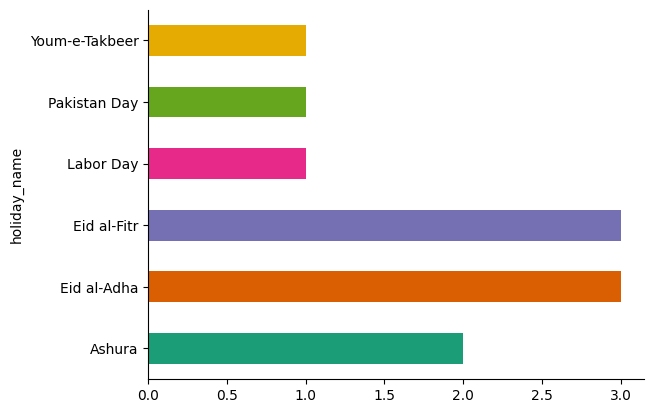

In [37]:
# @title holiday_name

from matplotlib import pyplot as plt
import seaborn as sns
hol_df.groupby('holiday_name').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

## **Synthetic Health Data Correlated with Air Quality**


In [38]:
import numpy as np
import pandas as pd

# Load daily AQ and weather
aq = pd.read_csv(RAW / "air_quality_daily_openmeteo.csv", parse_dates=["date"])
wx = pd.read_csv(RAW / "weather_data.csv", parse_dates=["date"])

# Merge minimally to get pm25 + humidity for generating health
tmp = pd.merge(
    aq[["date", "pm25_ugm3"]],
    wx[["date", "relative_humidity_2m_max"]],
    on="date",
    how="inner"
)

# Create lagged PM2.5 (yesterday & 2-days-ago)
tmp = tmp.sort_values("date")
tmp["pm25_lag1"] = tmp["pm25_ugm3"].shift(1)
tmp["pm25_lag2"] = tmp["pm25_ugm3"].shift(2)

# Parameters for synthetic ER/clinic respiratory cases
np.random.seed(42)
base = 40                                    # base cases/day
alpha = 0.6                                  # weight for current pm25
beta  = 0.4                                  # weight for lagged pm25
gamma = 0.05                                 # small effect of humidity (max RH)
noise = np.random.normal(0, 6, size=len(tmp))# random noise

cases = (
    base
    + alpha * tmp["pm25_ugm3"].fillna(tmp["pm25_ugm3"].median())
    + beta  * tmp["pm25_lag1"].fillna(tmp["pm25_ugm3"].median())
    + gamma * tmp["relative_humidity_2m_max"].fillna(tmp["relative_humidity_2m_max"].median())
    + noise
)

# Clean up to integers / non-negative
tmp["respiratory_cases"] = np.clip(cases.round().astype(int), 0, None)

health_df = tmp[["date", "respiratory_cases"]].copy()

# Save
health_path = RAW / "synthetic_health.csv"
health_df.to_csv(health_path, index=False)
print(f"Synthetic health saved: {health_path}")
health_df.head()


Synthetic health saved: /content/karachi_livability/data/raw/synthetic_health.csv


,date,respiratory_cases
0,2025-02-11,75
1,2025-02-12,86
2,2025-02-13,98
3,2025-02-14,90
4,2025-02-15,71


## **Merge Weather, Air Quality, Holidays, and Health Data into a Single Dataset**


In [40]:


import pandas as pd

# Load CSVs
wx = pd.read_csv(RAW / "weather_data.csv", parse_dates=["date"])
aq = pd.read_csv(RAW / "air_quality_daily_openmeteo.csv", parse_dates=["date"])
hol = pd.read_csv(RAW / "pakistan_holidays.csv", parse_dates=["date"])
hlth = pd.read_csv(RAW / "synthetic_health.csv", parse_dates=["date"])

# Ensure 'date' columns have no timezone
for df in [wx, aq, hol, hlth]:
    df["date"] = pd.to_datetime(df["date"]).dt.tz_localize(None)

# Merge all on 'date'
df = (wx.merge(aq, on="date", how="inner")
        .merge(hol, on="date", how="left")
        .merge(hlth, on="date", how="left"))

# Fill holiday name with None where not holiday
df["holiday_name"] = df["holiday_name"].astype(object)

# Save processed dataset
merged_path = PROCESSED / "karachi_daily_merged.csv"
df.to_csv(merged_path, index=False)

print(f"Merged dataset saved: {merged_path}")
print("Rows:", len(df), "| Columns:", len(df.columns))
df.head()


Merged dataset saved: /content/karachi_livability/data/processed/karachi_daily_merged.csv
Rows: 181 | Columns: 15


,temperature_2m_max,temperature_2m_min,precipitation_sum,windspeed_10m_max,relative_humidity_2m_max,date,pm10_ugm3,pm25_ugm3,co_ugm3,no2_ugm3,so2_ugm3,o3_ugm3,is_holiday,holiday_name,respiratory_cases
0,27.7,20.4,0.0,12.7,95.0,2025-02-11,79.679167,29.516667,447.916667,18.037500,12.541667,79.125000,0,NaN,75
1,29.0,17.9,0.0,10.7,88.0,2025-02-12,114.404167,50.795833,853.208333,34.933333,22.658333,70.875000,0,NaN,86
2,28.3,18.2,0.0,11.1,81.0,2025-02-13,85.995833,49.954167,989.708333,42.070833,29.358333,68.666667,0,NaN,98
3,29.7,19.8,0.0,14.7,89.0,2025-02-14,57.600000,27.462500,428.833333,22.550000,12.700000,72.875000,0,NaN,90
4,29.4,22.0,0.0,16.2,84.0,2025-02-15,67.016667,29.412500,359.708333,16.983333,11.008333,81.625000,0,NaN,71


## **Karachi Daily Dataset (Weather, Air Quality, Holidays, Health)**


In [42]:
# Merge Weather, Air Quality, Holidays, and Health Data into a Single Dataset

import pandas as pd

# Read CSV files
wx  = pd.read_csv(RAW / "weather_data.csv", parse_dates=["date"])
aq  = pd.read_csv(RAW / "air_quality_daily_openmeteo.csv", parse_dates=["date"])
hol = pd.read_csv(RAW / "pakistan_holidays.csv", parse_dates=["date"])
hlth= pd.read_csv(RAW / "synthetic_health.csv", parse_dates=["date"])

# Normalize all 'date' columns to timezone-naive (no UTC)
for d in (wx, aq, hol, hlth):
    d["date"] = pd.to_datetime(d["date"], utc=True).dt.tz_localize(None)

# Merge all on 'date'
df = (
    wx.merge(aq,  on="date", how="inner")
      .merge(hol, on="date", how="left")
      .merge(hlth,on="date", how="left")
)

# Ensure holiday_name is a plain object column
df["holiday_name"] = df["holiday_name"].astype(object)

# Save processed dataset
merged_path = PROCESSED / "karachi_daily_merged.csv"
df.to_csv(merged_path, index=False)

print(f"Merged dataset saved: {merged_path}")
print("Rows:", len(df), "| Columns:", len(df.columns))
df.head()


Merged dataset saved: /content/karachi_livability/data/processed/karachi_daily_merged.csv
Rows: 181 | Columns: 15


,temperature_2m_max,temperature_2m_min,precipitation_sum,windspeed_10m_max,relative_humidity_2m_max,date,pm10_ugm3,pm25_ugm3,co_ugm3,no2_ugm3,so2_ugm3,o3_ugm3,is_holiday,holiday_name,respiratory_cases
0,27.7,20.4,0.0,12.7,95.0,2025-02-11,79.679167,29.516667,447.916667,18.037500,12.541667,79.125000,0,NaN,75
1,29.0,17.9,0.0,10.7,88.0,2025-02-12,114.404167,50.795833,853.208333,34.933333,22.658333,70.875000,0,NaN,86
2,28.3,18.2,0.0,11.1,81.0,2025-02-13,85.995833,49.954167,989.708333,42.070833,29.358333,68.666667,0,NaN,98
3,29.7,19.8,0.0,14.7,89.0,2025-02-14,57.600000,27.462500,428.833333,22.550000,12.700000,72.875000,0,NaN,90
4,29.4,22.0,0.0,16.2,84.0,2025-02-15,67.016667,29.412500,359.708333,16.983333,11.008333,81.625000,0,NaN,71


## **Feature Engineering: Lags, Rolling Means, and AQI Index Calculation**


In [43]:
import pandas as pd

df = pd.read_csv(PROCESSED / "karachi_daily_merged.csv", parse_dates=["date"])
df = df.sort_values("date")

# Lags for PM2.5
for k in [1, 3, 7]:
    df[f"pm25_lag{k}"] = df["pm25_ugm3"].shift(k)

# Rolling means (7-day)
roll_cols = ["pm25_ugm3","pm10_ugm3","no2_ugm3","o3_ugm3",
             "temperature_2m_max","temperature_2m_min","relative_humidity_2m_max",
             "windspeed_10m_max","precipitation_sum"]
for c in roll_cols:
    if c in df.columns:
        df[f"{c}_roll7"] = df[c].rolling(7, min_periods=3).mean()

# Simple AQI-like index (placeholder): normalize pm25 (0–150 ug/m3) to 0–100 (higher = worse)
pm25_clip = df["pm25_ugm3"].clip(0, 150)
df["pm25_index_0to100"] = (pm25_clip / 150.0 * 100).round(1)

# Save engineered
eng_path = PROCESSED / "karachi_daily_features.csv"
df.to_csv(eng_path, index=False)
print(f"Features saved: {eng_path}")
df.tail(3)


Features saved: /content/karachi_livability/data/processed/karachi_daily_features.csv


,temperature_2m_max,temperature_2m_min,precipitation_sum,windspeed_10m_max,relative_humidity_2m_max,date,pm10_ugm3,pm25_ugm3,co_ugm3,no2_ugm3,...,pm25_ugm3_roll7,pm10_ugm3_roll7,no2_ugm3_roll7,o3_ugm3_roll7,temperature_2m_max_roll7,temperature_2m_min_roll7,relative_humidity_2m_max_roll7,windspeed_10m_max_roll7,precipitation_sum_roll7,pm25_index_0to100
178,30.7,26.2,0.9,19.3,89.0,2025-08-08,42.591667,18.650000,223.041667,8.712500,...,20.118452,51.829762,10.031548,53.773810,30.271429,26.300000,90.428571,19.385714,1.700000,12.4
179,NaN,NaN,NaN,NaN,NaN,2025-08-09,39.275000,17.291667,212.125000,8.820833,...,19.496429,48.582738,9.602976,53.714286,30.333333,26.266667,90.333333,19.350000,1.633333,11.5
180,NaN,NaN,NaN,NaN,NaN,2025-08-10,42.558333,19.050000,216.958333,8.495833,...,19.263690,46.029167,9.430952,52.750000,30.360000,26.220000,90.400000,19.660000,1.700000,12.7


## **Preview Engineered Features Dataset**


In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv(PROCESSED / "karachi_daily_features.csv", parse_dates=["date"])
df = df.sort_values("date")
df.head()


,temperature_2m_max,temperature_2m_min,precipitation_sum,windspeed_10m_max,relative_humidity_2m_max,date,pm10_ugm3,pm25_ugm3,co_ugm3,no2_ugm3,...,pm25_ugm3_roll7,pm10_ugm3_roll7,no2_ugm3_roll7,o3_ugm3_roll7,temperature_2m_max_roll7,temperature_2m_min_roll7,relative_humidity_2m_max_roll7,windspeed_10m_max_roll7,precipitation_sum_roll7,pm25_index_0to100
0,27.7,20.4,0.0,12.7,95.0,2025-02-11,79.679167,29.516667,447.916667,18.037500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.7
1,29.0,17.9,0.0,10.7,88.0,2025-02-12,114.404167,50.795833,853.208333,34.933333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.9
2,28.3,18.2,0.0,11.1,81.0,2025-02-13,85.995833,49.954167,989.708333,42.070833,...,43.422222,93.359722,31.680556,72.888889,28.333333,18.833333,88.00,11.50,0.0,33.3
3,29.7,19.8,0.0,14.7,89.0,2025-02-14,57.600000,27.462500,428.833333,22.550000,...,39.432292,84.419792,29.397917,72.885417,28.675000,19.075000,88.25,12.30,0.0,18.3
4,29.4,22.0,0.0,16.2,84.0,2025-02-15,67.016667,29.412500,359.708333,16.983333,...,37.428333,80.939167,26.915000,74.633333,28.820000,19.660000,87.40,13.08,0.0,19.6


## **Visualization of Daily PM2.5 Levels in Karachi with WHO Guidelines**


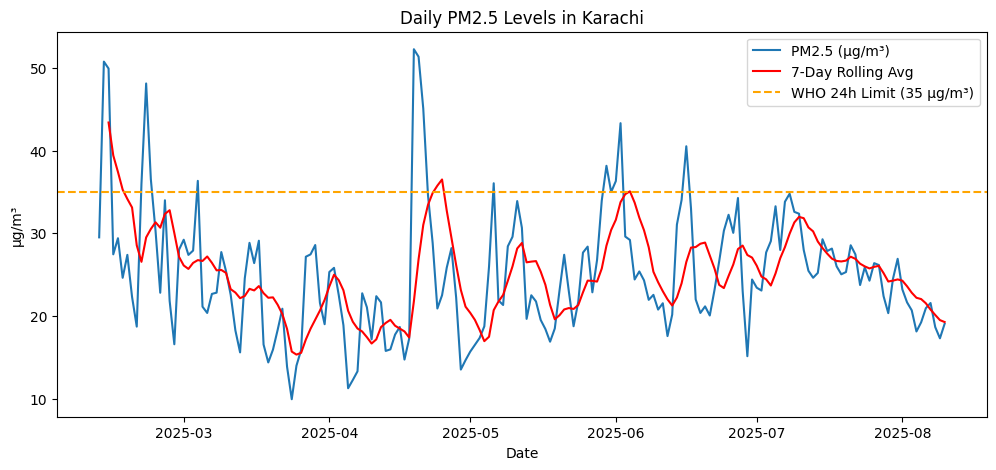

In [20]:
plt.figure(figsize=(12,5))
sns.lineplot(data=df, x="date", y="pm25_ugm3", label="PM2.5 (µg/m³)")
sns.lineplot(data=df, x="date", y="pm25_ugm3_roll7", label="7-Day Rolling Avg", color="red")
plt.axhline(35, color="orange", linestyle="--", label="WHO 24h Limit (35 µg/m³)")
plt.title("Daily PM2.5 Levels in Karachi")
plt.ylabel("µg/m³")
plt.xlabel("Date")
plt.legend()
plt.show()


## **Scatter Plot: Max Temperature vs. PM2.5 Levels (Holidays vs. Non-Holidays)**


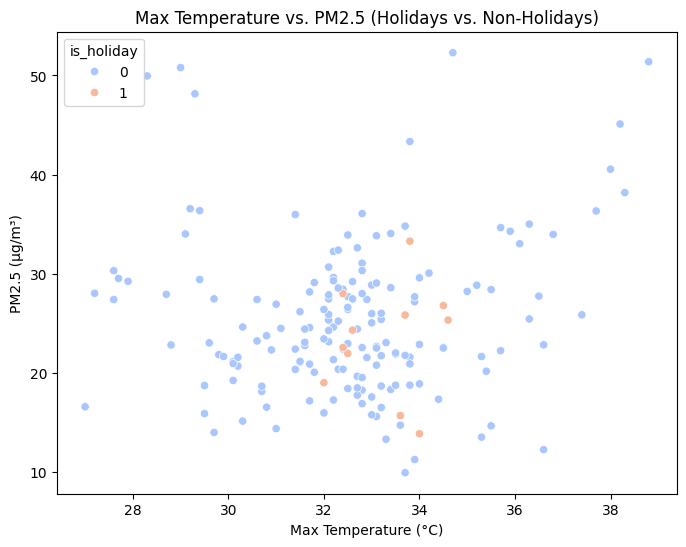

In [21]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="temperature_2m_max", y="pm25_ugm3", hue="is_holiday", palette="coolwarm")
plt.title("Max Temperature vs. PM2.5 (Holidays vs. Non-Holidays)")
plt.xlabel("Max Temperature (°C)")
plt.ylabel("PM2.5 (µg/m³)")
plt.show()


## **Correlation Heatmap of Weather and Air Quality Variables**


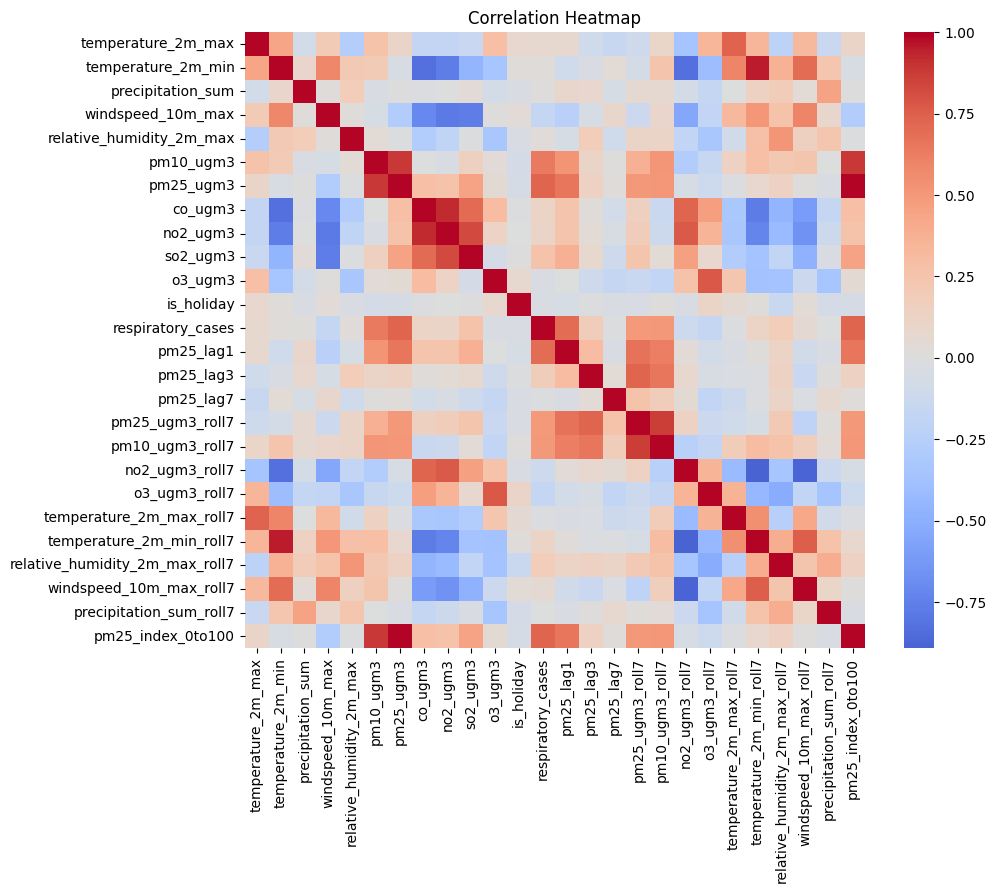

In [22]:
plt.figure(figsize=(10,8))
corr = df.select_dtypes(include="number").corr()
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.show()


**## Respiratory Cases vs. PM2.5 Index Over Time**


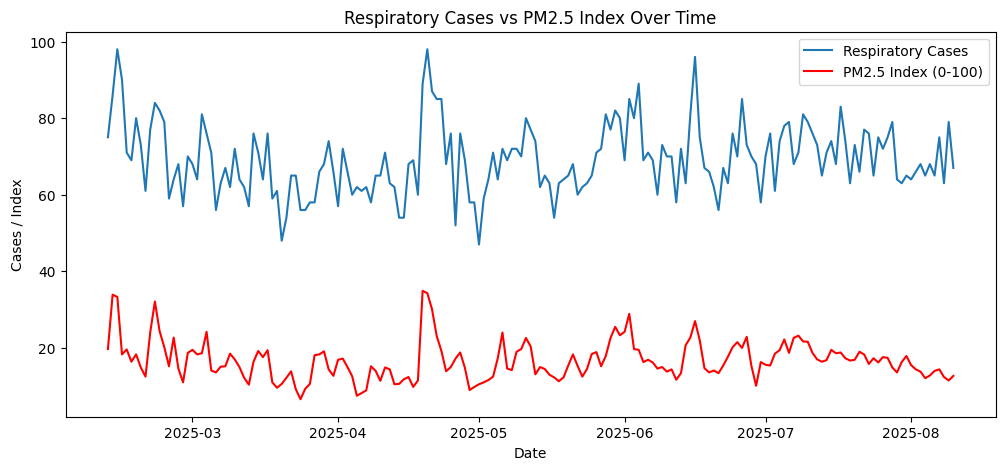

In [23]:
plt.figure(figsize=(12,5))
sns.lineplot(data=df, x="date", y="respiratory_cases", label="Respiratory Cases")
sns.lineplot(data=df, x="date", y="pm25_index_0to100", label="PM2.5 Index (0-100)", color="red")
plt.title("Respiratory Cases vs PM2.5 Index Over Time")
plt.ylabel("Cases / Index")
plt.xlabel("Date")
plt.legend()
plt.show()


## **Karachi Livability Index**


In [44]:
df = pd.read_csv(PROCESSED / "karachi_daily_features.csv", parse_dates=["date"])

# --- Scores ---
# Air quality score (0–100, 100 = cleanest)
df["aq_score"] = (100 - df["pm25_index_0to100"]).clip(0, 100)

# Temperature comfort score (penalty for being far from 25°C)
ideal_temp = 25
df["temp_score"] = (100 - (abs(df["temperature_2m_max"] - ideal_temp) * 3)).clip(0, 100)

# Humidity comfort score (40–60% ideal)
df["humidity_score"] = (100 - abs(df["relative_humidity_2m_max"] - 50) * 2).clip(0, 100)

# --- Final index (weights can be adjusted) ---
df["livability_index"] = (
    0.5 * df["aq_score"] +
    0.3 * df["temp_score"] +
    0.2 * df["humidity_score"]
).round(1)

# Save
liv_path = PROCESSED / "karachi_livability_index.csv"
df.to_csv(liv_path, index=False)
print(f"Livability index saved: {liv_path}")

df[["date","aq_score","temp_score","humidity_score","livability_index"]].head()


Livability index saved: /content/karachi_livability/data/processed/karachi_livability_index.csv


,date,aq_score,temp_score,humidity_score,livability_index
0,2025-02-11,80.3,91.9,10.0,69.7
1,2025-02-12,66.1,88.0,24.0,64.2
2,2025-02-13,66.7,90.1,38.0,68.0
3,2025-02-14,81.7,85.9,22.0,71.0
4,2025-02-15,80.4,86.8,32.0,72.6


## **Plotting Karachi Livability Index with Moderate Threshold**


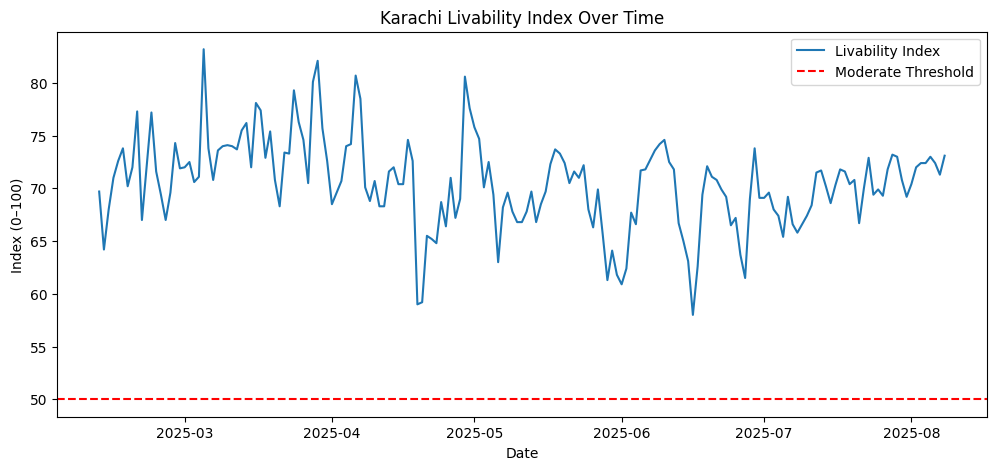

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,5))
sns.lineplot(data=df, x="date", y="livability_index", label="Livability Index")
plt.axhline(50, color="red", linestyle="--", label="Moderate Threshold")
plt.title("Karachi Livability Index Over Time")
plt.ylabel("Index (0–100)")
plt.xlabel("Date")
plt.legend()
plt.show()
